In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import json

from matplotlib import pyplot as pp
%pylab inline
pp.rcParams['figure.figsize'] = (15,15)
import re
import seaborn as sns
sns.set_style('darkgrid')

from datetime import datetime as dt, timezone as tz, timedelta as td
from itertools import chain

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', 1000)

Populating the interactive namespace from numpy and matplotlib


### read data

In [2]:
def read_file(filename):
    df = pd.read_csv(filename, sep='\t', encoding='utf-8')
    print(df.shape)
    return df

In [3]:
equipment = read_file("../data/equipment.tsv")
equipment['class'] = equipment['class'].str.replace('\\xa0', ' ')
equipment.set_index('id', inplace=True)
equipment.head()

(541, 4)


,class,available_hours,speed_per_hour
id,,,
7596f724-c038-11e6-80c1-e1497160343b,Масс-спектрометр,NaN,60
0ea79b45-aa16-11e5-80d6-00505692e771,Бокс химической защиты с двойной системой фильтрации,NaN,100
e2de4578-93a6-11e7-80da-00155df02900,Хроматограф газовый,NaN,55
cd806b45-26fd-11e5-80c0-00505692e771,Весы,NaN,95
8392404a-f2a4-11e6-80d2-00155df02900,Хроматограф жидкостный,NaN,70


In [4]:
def fix_date_format(dt):
    y, m, d = dt.split('-')
    m = ('0'+m)[-2:]
    d = ('0'+d)[-2:]
    return '-'.join((y,m,d))

In [5]:
orders = read_file("../data/order.tsv")
orders['deadline'] = orders.deadline.apply(fix_date_format)
orders.set_index('_id', inplace=True)
orders.head()

(124949, 4)


,product_id,amount,deadline
_id,,,
0,5c94953dc9e77c0001d5e130,520,2019-04-01
1,5c94953dc9e77c0001d5e12b,1000,2019-04-03
2,5c94953dc9e77c0001d5e131,360,2019-04-10
3,5c94953dc9e77c0001d5e141,90,2019-03-25
4,5c94953dc9e77c0001d5e139,860,2019-04-16


In [6]:
orders.deadline.min()

'2019-03-22'

In [7]:
orders.groupby("product_id")['amount'].sum()

product_id
5c94953dc9e77c0001d5e121    1790540
5c94953dc9e77c0001d5e122    1764620
5c94953dc9e77c0001d5e123    1775480
5c94953dc9e77c0001d5e124    1769530
5c94953dc9e77c0001d5e125    1725090
5c94953dc9e77c0001d5e126    1776310
5c94953dc9e77c0001d5e127    1763280
5c94953dc9e77c0001d5e128    1767630
5c94953dc9e77c0001d5e129    1765300
5c94953dc9e77c0001d5e12a    1782380
5c94953dc9e77c0001d5e12b    1788300
5c94953dc9e77c0001d5e12c    1783690
5c94953dc9e77c0001d5e12d    1763990
5c94953dc9e77c0001d5e12e    1795520
5c94953dc9e77c0001d5e12f    1750150
5c94953dc9e77c0001d5e130    1778150
5c94953dc9e77c0001d5e131    1774410
5c94953dc9e77c0001d5e132    1774700
5c94953dc9e77c0001d5e133    1783990
5c94953dc9e77c0001d5e134    1746130
5c94953dc9e77c0001d5e135    1761170
5c94953dc9e77c0001d5e136    1769550
5c94953dc9e77c0001d5e137    1773810
5c94953dc9e77c0001d5e138    1767910
5c94953dc9e77c0001d5e139    1766820
5c94953dc9e77c0001d5e13a    1786480
5c94953dc9e77c0001d5e13b    1791420
5c94953dc9e77c000

In [8]:
products = read_file("../data/product.tsv")
products['equipment_class'] = products['equipment_class'].apply(
    lambda x: json.loads(x.replace("'", '"').replace("\\xa0", " ")))
products.set_index('_id', inplace=True)
products.head()

(37, 2)


,equipment_class
_id,
5c94953dc9e77c0001d5e130,"[Хроматограф жидкостный, Насос, Принтер для этикеток, Сухожаровой шкаф, Автостейнер]"
5c94953dc9e77c0001d5e12b,"[Вытяжной шкаф, pH-метр, Система капиллярного электрофореза]"
5c94953dc9e77c0001d5e131,"[Манипулятор переносящий, Криохранилище, Высокоскоростной смеситель-гранулятор, Хромато-масс-спектрометр]"
5c94953dc9e77c0001d5e141,"[Рециркулятор, Изолятор, Счетчик клеток]"
5c94953dc9e77c0001d5e139,"[Лабораторное оборудование, Синтезатор олигонуклеотидов, Производственное оборудование, Шейкер, Амплификатор, Изолятор, Аппарат для определения растворимости таблеток, Лабораторный 3D смеситель]"


In [9]:
equipment_hist = read_file("../data/eq_hist_data.tsv")
equipment_hist.head()

(93052, 6)


,day,id,work,maintenance,idle,class
0,1538438400,7596f724-c038-11e6-80c1-e1497160343b,0,0,24,Масс-спектрометр
1,1538438400,0ea79b45-aa16-11e5-80d6-00505692e771,0,0,24,Бокс химической защиты с двойной системой фильтрации
2,1538438400,e2de4578-93a6-11e7-80da-00155df02900,24,0,0,Хроматограф газовый
3,1538438400,cd806b45-26fd-11e5-80c0-00505692e771,24,0,0,Весы
4,1538438400,8392404a-f2a4-11e6-80d2-00155df02900,24,0,0,Хроматограф жидкостный


### check that all equipment classes are read properly

In [10]:
product_equipments = set([v for l in products.equipment_class.values for v in l])

In [11]:
product_equipments - set(equipment["class"].values.tolist())

set()

In [12]:
equipment['class'].nunique()

116

### EDA

In [13]:
# schedule = {%equipment_id%: 
# [{'order_id': %order_id%, 'amount': %order_amount%, 'start': %datetime%, 'end': %datetime%}, ...], ...}


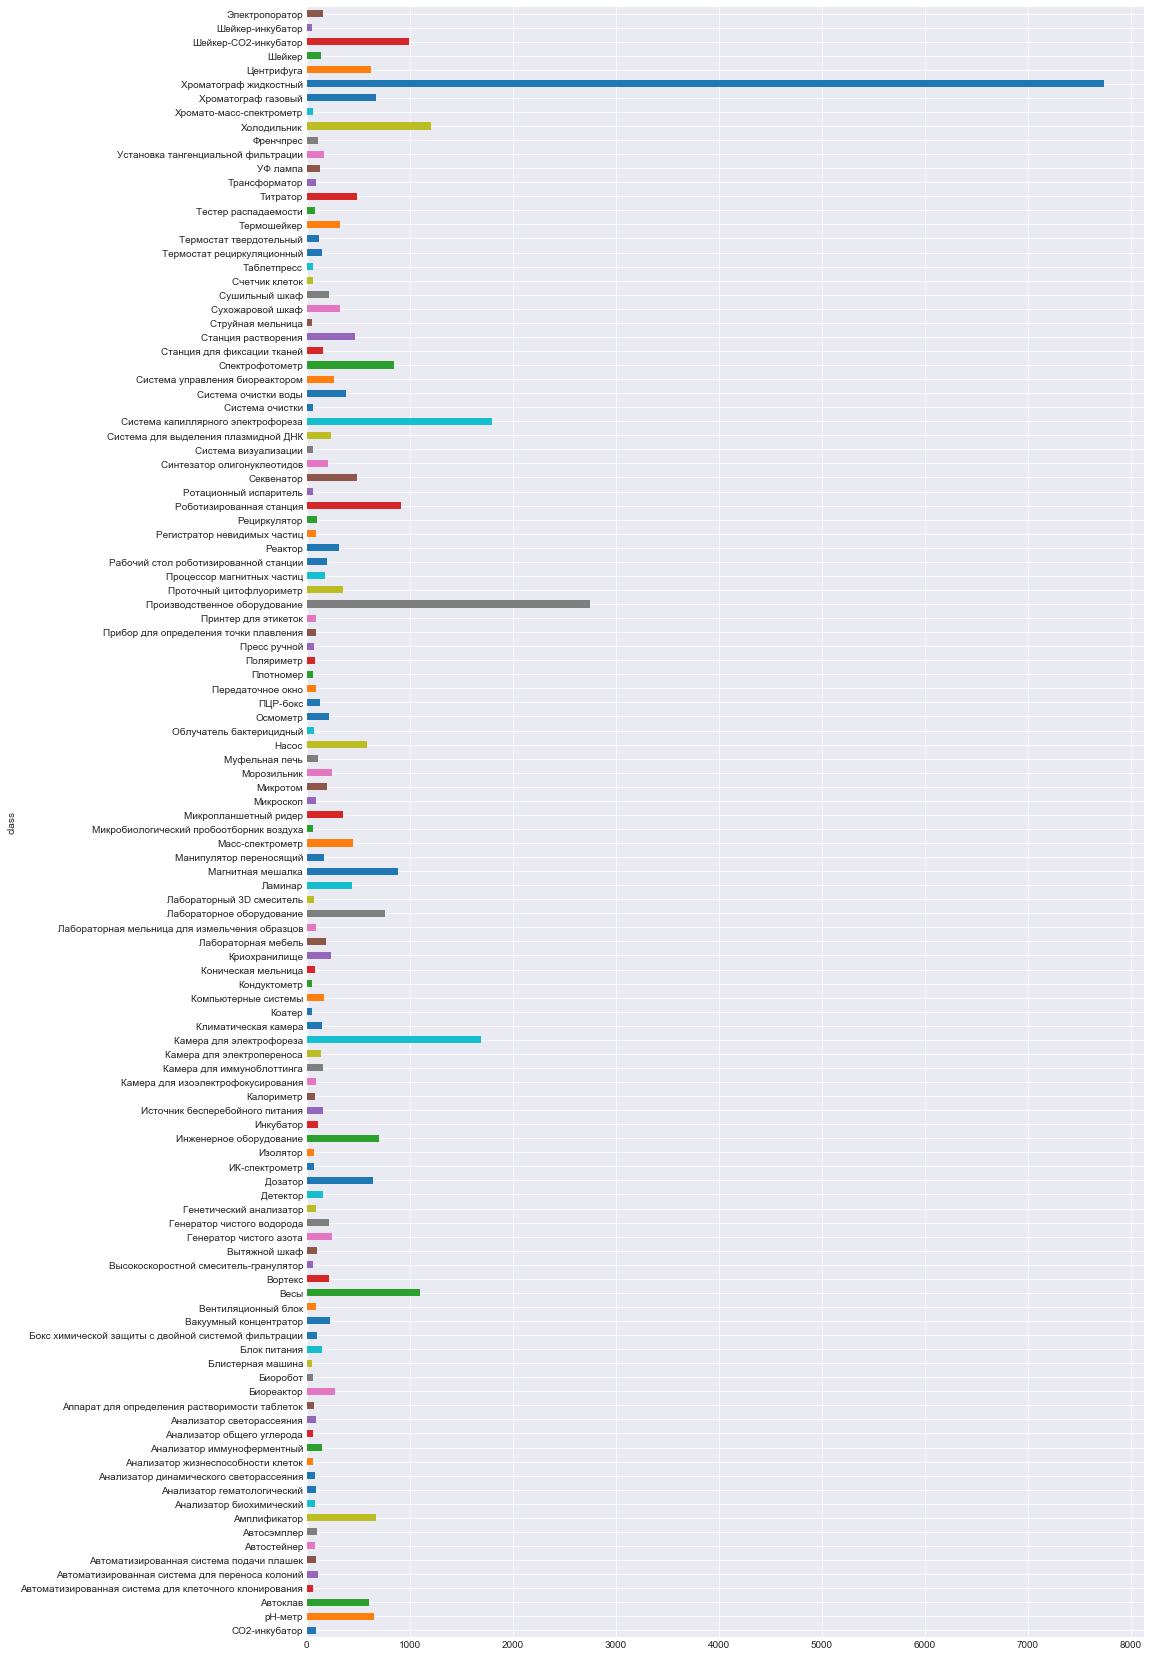

In [14]:
pp.figure(figsize=(15,30))
equipment.groupby('class')['speed_per_hour'].sum().sort_index().plot.barh()

In [15]:
orders_one_day = (orders[orders['deadline']=='2019-03-22']
                  .merge(products, left_on='product_id', right_index=True, suffixes=('', '_y'))
                  .drop(['deadline'], axis=1))
orders_one_day.shape

(4169, 3)

In [16]:
orders_one_day.head()

,product_id,amount,equipment_class
_id,,,
42,5c94953dc9e77c0001d5e142,680,"[Вакуумный концентратор, Титратор, Насос, Анализатор биохимический, Источник бесперебойного питания, Лабораторная мельница для измельчения образцов, Трансформатор, Система очистки, Таблетпресс]"
2696,5c94953dc9e77c0001d5e142,920,"[Вакуумный концентратор, Титратор, Насос, Анализатор биохимический, Источник бесперебойного питания, Лабораторная мельница для измельчения образцов, Трансформатор, Система очистки, Таблетпресс]"
3660,5c94953dc9e77c0001d5e142,880,"[Вакуумный концентратор, Титратор, Насос, Анализатор биохимический, Источник бесперебойного питания, Лабораторная мельница для измельчения образцов, Трансформатор, Система очистки, Таблетпресс]"
4301,5c94953dc9e77c0001d5e142,560,"[Вакуумный концентратор, Титратор, Насос, Анализатор биохимический, Источник бесперебойного питания, Лабораторная мельница для измельчения образцов, Трансформатор, Система очистки, Таблетпресс]"
5588,5c94953dc9e77c0001d5e142,60,"[Вакуумный концентратор, Титратор, Насос, Анализатор биохимический, Источник бесперебойного питания, Лабораторная мельница для измельчения образцов, Трансформатор, Система очистки, Таблетпресс]"


In [17]:
res = []
for idx, row in orders_one_day.reset_index().to_dict(orient='index').items():
    classes = row['equipment_class']
    row.pop('equipment_class')
    total_amount = 0
    for c in classes:
        row_on_class = row.copy()
        row_on_class['equipment_class'] = c
        row_on_class['amount'] = int(np.ceil(row_on_class['amount'] / len(classes)))
        total_amount += row_on_class['amount']
        if total_amount > row['amount']:
            row_on_class['amount'] -= (total_amount - row['amount'])
            total_amount = row['amount']
        res.append(row_on_class)
orders_one_day = pd.DataFrame(res)
orders_one_day.head(n=10)

,_id,amount,equipment_class,product_id
0,42,76,Вакуумный концентратор,5c94953dc9e77c0001d5e142
1,42,76,Титратор,5c94953dc9e77c0001d5e142
2,42,76,Насос,5c94953dc9e77c0001d5e142
3,42,76,Анализатор биохимический,5c94953dc9e77c0001d5e142
4,42,76,Источник бесперебойного питания,5c94953dc9e77c0001d5e142
5,42,76,Лабораторная мельница для измельчения образцов,5c94953dc9e77c0001d5e142
6,42,76,Трансформатор,5c94953dc9e77c0001d5e142
7,42,76,Система очистки,5c94953dc9e77c0001d5e142
8,42,72,Таблетпресс,5c94953dc9e77c0001d5e142
9,2696,103,Вакуумный концентратор,5c94953dc9e77c0001d5e142


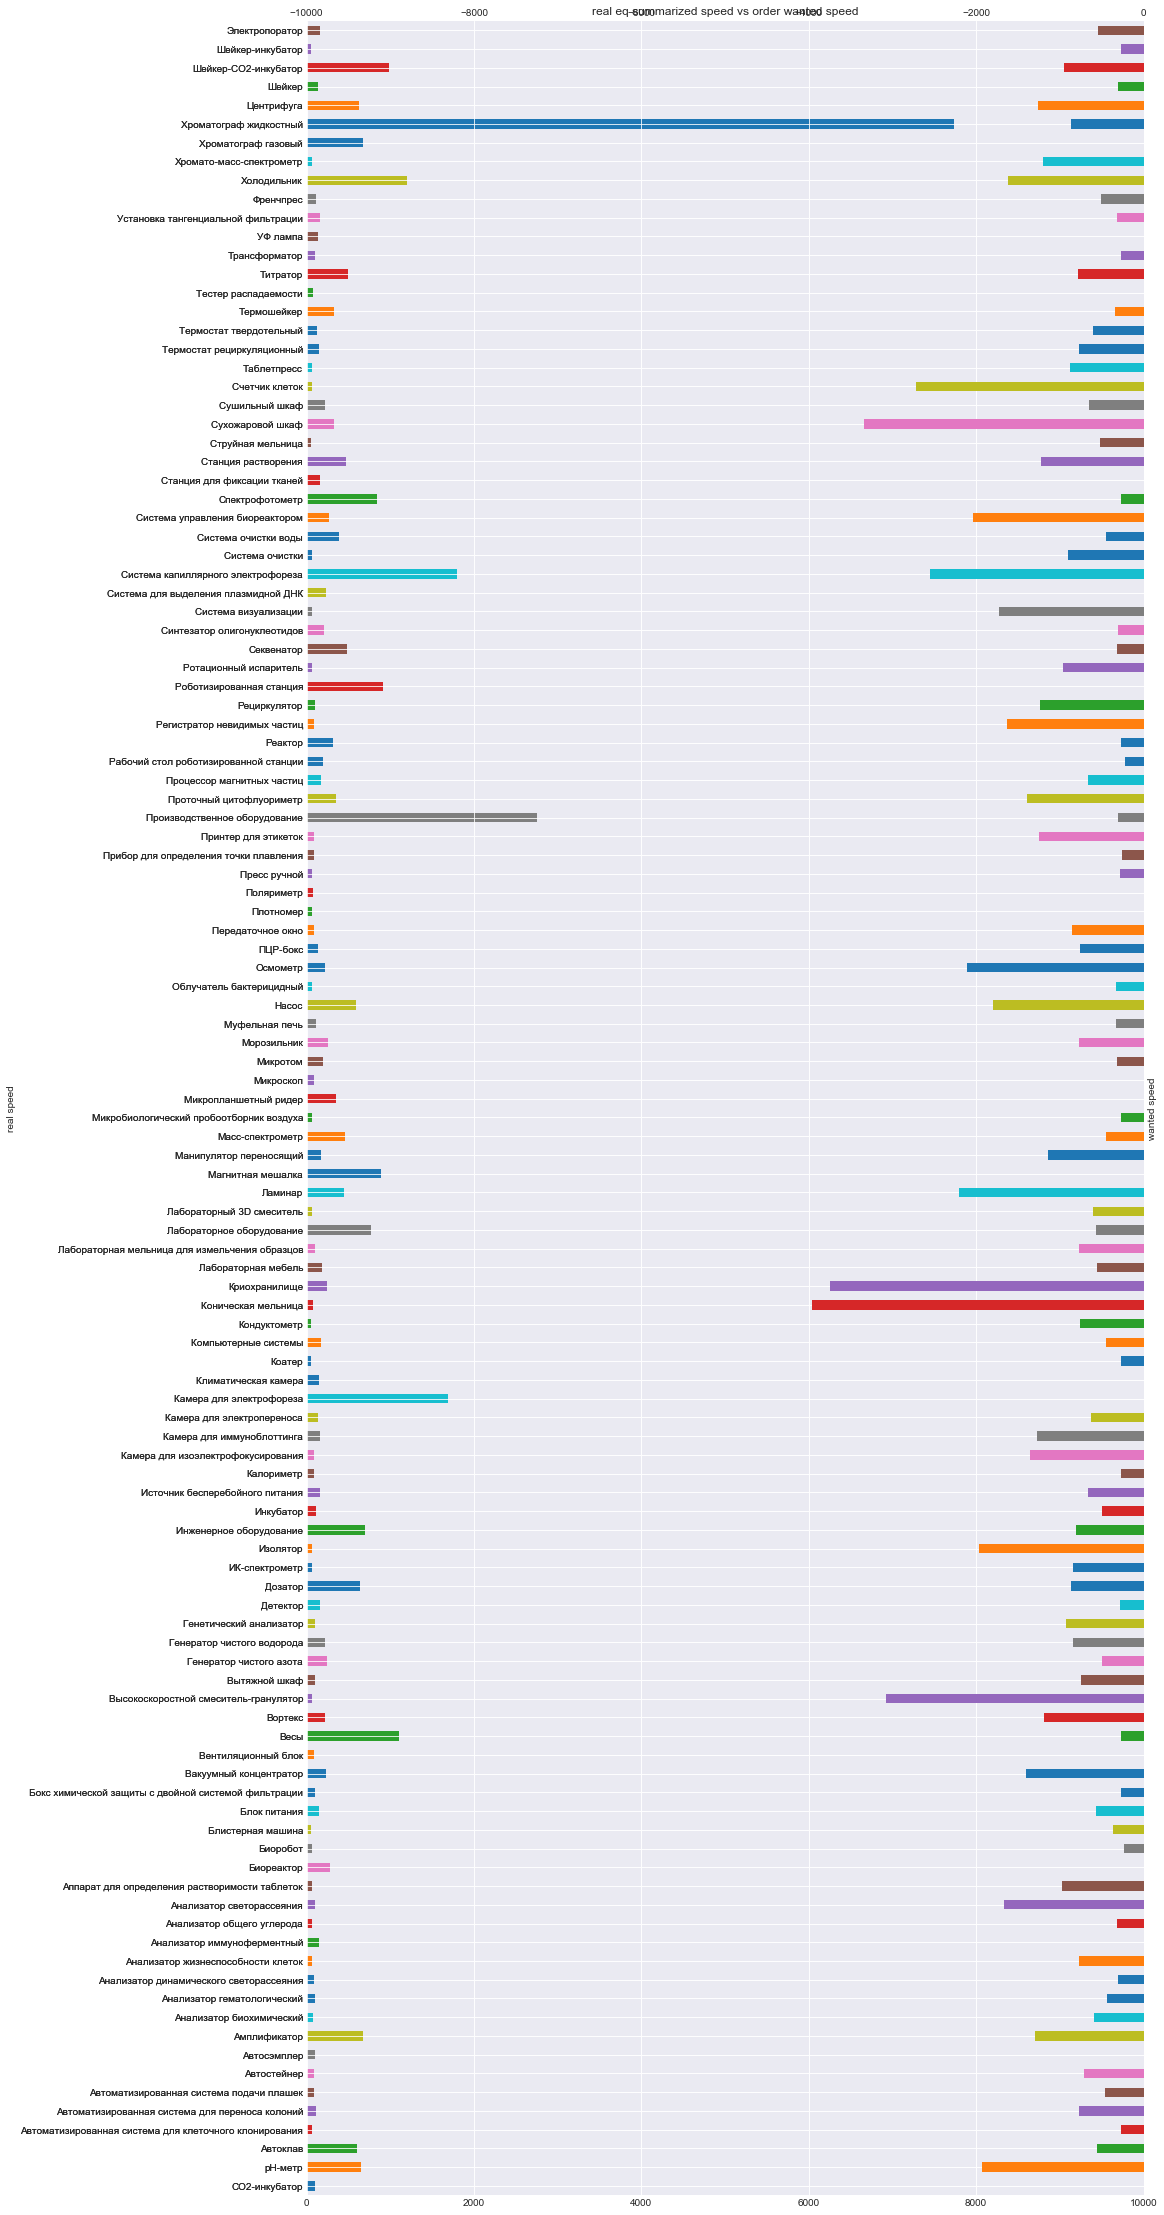

In [18]:
fig,axt = pp.subplots(1, figsize=(15,40))
equipment_classes_aggregated = equipment.groupby('class')['speed_per_hour'].sum().sort_index()
necessary_classes = equipment_classes_aggregated.index

equipment_classes_aggregated.plot.barh()
pp.title("real eq summarized speed vs order wanted speed")

axb = axt.twiny()

(orders_one_day.groupby('equipment_class')['amount'].sum()[necessary_classes].fillna(0) / -24).plot.barh(ax=axb)

# Set some sensible axes limits
axt.set_xlim(0,10000)
axb.set_xlim(-10000,0)

# Add some axes labels
axt.set_ylabel('real speed')
axb.set_ylabel('wanted speed')

# Need to manually move axb label to right hand side
axb.yaxis.set_label_position('right')
pp.show()


In [19]:
total_possible_speed = equipment.speed_per_hour.sum() * 24
print('total speed per day for all equipments, it/day:', total_possible_speed)
print('total awaited products: ', orders.groupby('deadline')['amount'].sum())

total speed per day for all equipments, it/day: 974040
total awaited products:  deadline
2019-03-22    2182830
2019-03-23    2194330
2019-03-24    2188060
2019-03-25    2195910
2019-03-26    2168320
2019-03-27    2208390
2019-03-28    2186920
2019-03-29    2195470
2019-03-30    2180550
2019-03-31    2199410
2019-04-01    2160240
2019-04-02    2157890
2019-04-03    2183860
2019-04-04    2183850
2019-04-05    2170960
2019-04-06    2161580
2019-04-07    2173890
2019-04-08    2184270
2019-04-09    2192370
2019-04-10    2195130
2019-04-11    2173380
2019-04-12    2179770
2019-04-13    2165780
2019-04-14    2231130
2019-04-15    2203130
2019-04-16    2217440
2019-04-17    2181950
2019-04-18    2201510
2019-04-19    2177640
2019-04-20    2200660
Name: amount, dtype: int64


Отстой. Можностей в 2 раза меньше, чем поступает заказов

In [43]:
total_possible_speed*25 / orders['amount'].sum()

0.3712233953517727

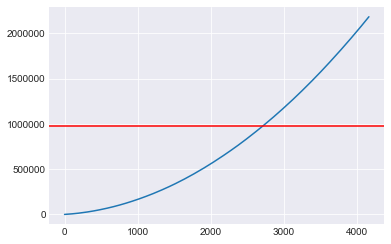

In [20]:
pp.plot(orders_one_day.groupby('_id')['amount'].sum().sort_values().cumsum().values)
pp.axhline(total_possible_speed, color='red')

Если брать в работу только самые маленькие заказы, сколько мы теоретически могли бы успевать обработать? (с учетом, что заказы поступают 7 дней в неделю, а оборудование работает только 5 дней)

In [21]:
orders_one_day.describe()

,_id,amount
count,21937.000000,21937.00000
mean,63731.870857,99.50449
std,35777.909943,105.11317
min,42.000000,1.00000
25%,33562.000000,40.00000
50%,64321.000000,76.00000
75%,94282.000000,113.00000
max,124948.000000,1000.00000


In [46]:
(orders['amount'].sort_values().cumsum() < total_possible_speed*25).sum()

73646

In [22]:
(orders_one_day.groupby('_id')['amount'].sum().sort_values().cumsum() < total_possible_speed*5/7).mean()

0.5418565603262173

### Try to locate all orders

In [23]:
orders.sort_values(['deadline', 'amount'], inplace=True)
orders.head()

,product_id,amount,deadline
_id,,,
1620,5c94953dc9e77c0001d5e13c,50,2019-03-22
18516,5c94953dc9e77c0001d5e140,50,2019-03-22
29637,5c94953dc9e77c0001d5e144,50,2019-03-22
35931,5c94953dc9e77c0001d5e142,50,2019-03-22
44093,5c94953dc9e77c0001d5e12e,50,2019-03-22


In [24]:
dt.strptime("2019-03-22", "%Y-%m-%d")

datetime.datetime(2019, 3, 22, 0, 0)

In [25]:
def diff_dates(dt1, dt2):
    return (dt.strptime(dt1, "%Y-%m-%d") - dt.strptime(dt2, "%Y-%m-%d")).days

In [26]:
diff_dates("2019-03-22", "2019-03-21")

1

In [27]:
def is_weekend(dt1):
    return dt.strptime(dt1, "%Y-%m-%d").weekday() > 4

In [28]:
def get_possible_equipments_for_product():
    possible_equipments_for_product = {}
    equipment_by_class = equipment.reset_index().set_index(['class', 'id'])
    for product_id, possible_classes in products['equipment_class'].iteritems():
        res = []
        for c_name in possible_classes:
            possible_equipments = equipment_by_class.loc[c_name]
            for eq_id, eq_row in possible_equipments.iterrows():
                res.append({"id": eq_id, "speed": eq_row['speed_per_hour']})
        possible_equipments_for_product[product_id] = res
    return possible_equipments_for_product

possible_equipments_for_product = get_possible_equipments_for_product()

In [29]:
orders_dict = orders.to_dict(orient="index")

In [30]:
orders.sort_values(['deadline', 'amount'], inplace=True)

schedule = {eq_id: {"left_items": 0, "actions": []} for eq_id in equipment.index}
prev_date = "2019-03-17"
n_placed = 0
n_failed = 0
placed_orders_progress = tqdm(total=len(orders), desc="placed")
failed_orders_progress = tqdm(total=len(orders), desc="failed")

for idx, row in tqdm(orders_dict.items(), total=len(orders)):
    current_date = row['deadline']
    if prev_date != current_date:
        print(f"new date! {current_date}, good: {n_placed} , bad: {n_failed}")
        if not is_weekend(current_date):
            new_hours = diff_dates(current_date, prev_date) * 24
            for eq_id, v in schedule.items():
                v['left_items'] += new_hours * equipment.loc[eq_id, 'speed_per_hour']
        prev_date = current_date

    amount = row['amount']
    order_id = idx
    possible_equipments = possible_equipments_for_product[row['product_id']]
    best_eq = None
    best_eq_score = 0

    for eq in possible_equipments:
        eq_id = eq['id']
        current_score = schedule[eq_id]['left_items']
        if current_score > best_eq_score:
            best_eq = eq_id
            best_eq_score = current_score
    if best_eq and (best_eq_score >= amount):
        placed_orders_progress.update(1)
        n_placed += 1
        schedule[best_eq]["actions"].append({"order_id": order_id, "amount": amount})
        schedule[best_eq]["left_items"] -= amount
    else:
        failed_orders_progress.update(1)
        n_failed += 1
print(n_placed, n_failed)

HBox(children=(IntProgress(value=0, description='placed', max=124949), HTML(value='')))

HBox(children=(IntProgress(value=0, description='failed', max=124949), HTML(value='')))

HBox(children=(IntProgress(value=0, max=124949), HTML(value='')))

new date! 2019-03-22, good: 0 , bad: 0
new date! 2019-03-23, good: 3808 , bad: 361
new date! 2019-03-24, good: 6213 , bad: 2130
new date! 2019-03-25, good: 7276 , bad: 5231
new date! 2019-03-26, good: 9392 , bad: 7286
new date! 2019-03-27, good: 11582 , bad: 9269
new date! 2019-03-28, good: 13748 , bad: 11273
new date! 2019-03-29, good: 15905 , bad: 13260
new date! 2019-03-30, good: 18130 , bad: 15199
new date! 2019-03-31, good: 18952 , bad: 18537
new date! 2019-04-01, good: 19477 , bad: 22176
new date! 2019-04-02, good: 21570 , bad: 24257
new date! 2019-04-03, good: 23779 , bad: 26210
new date! 2019-04-04, good: 26004 , bad: 28159
new date! 2019-04-05, good: 28173 , bad: 30146
new date! 2019-04-06, good: 30354 , bad: 32121
new date! 2019-04-07, good: 31179 , bad: 35453
new date! 2019-04-08, good: 31697 , bad: 39096
new date! 2019-04-09, good: 33791 , bad: 41163
new date! 2019-04-10, good: 35966 , bad: 43148
new date! 2019-04-11, good: 38143 , bad: 45126
new date! 2019-04-12, good: 403

In [31]:
n_placed

55358

In [32]:
products.loc['5c94953dc9e77c0001d5e13c']

equipment_class    [Анализатор динамического светорассеяния, Струйная мельница, Генетический анализатор, Блок питания, Сухожаровой шкаф, Манипулятор переносящий, Система капиллярного электрофореза, Проточный цитофлуориметр]
Name: 5c94953dc9e77c0001d5e13c, dtype: object

In [33]:
[equipment.loc[v['id'], 'class'] for v in possible_equipments_for_product["5c94953dc9e77c0001d5e13c"]]

['Анализатор динамического светорассеяния',
 'Струйная мельница',
 'Генетический анализатор',
 'Блок питания',
 'Блок питания',
 'Сухожаровой шкаф',
 'Сухожаровой шкаф',
 'Сухожаровой шкаф',
 'Сухожаровой шкаф',
 'Манипулятор переносящий',
 'Манипулятор переносящий',
 'Система капиллярного электрофореза',
 'Система капиллярного электрофореза',
 'Система капиллярного электрофореза',
 'Система капиллярного электрофореза',
 'Система капиллярного электрофореза',
 'Система капиллярного электрофореза',
 'Система капиллярного электрофореза',
 'Система капиллярного электрофореза',
 'Система капиллярного электрофореза',
 'Система капиллярного электрофореза',
 'Система капиллярного электрофореза',
 'Система капиллярного электрофореза',
 'Система капиллярного электрофореза',
 'Система капиллярного электрофореза',
 'Система капиллярного электрофореза',
 'Система капиллярного электрофореза',
 'Система капиллярного электрофореза',
 'Система капиллярного электрофореза',
 'Система капиллярного электро

In [34]:
dt.strptime("2019-03-05", "%Y-%m-%d")+td()

datetime.datetime(2019, 3, 5, 0, 0)

In [35]:
orders.loc[26722]

product_id    5c94953dc9e77c0001d5e138
amount                             640
deadline                    2019-03-22
Name: 26722, dtype: object

In [37]:
equipment.loc['60a9ccfc-8ad0-11e8-80e5-00155df02900']

class              Хроматограф жидкостный
available_hours                       NaN
speed_per_hour                         95
Name: 60a9ccfc-8ad0-11e8-80e5-00155df02900, dtype: object

In [39]:
products[products.equipment_class.apply(lambda x: 'Хроматограф жидкостный' in x)]

,equipment_class
_id,
5c94953dc9e77c0001d5e130,"[Хроматограф жидкостный, Насос, Принтер для этикеток, Сухожаровой шкаф, Автостейнер]"
5c94953dc9e77c0001d5e127,"[Амплификатор, Холодильник, Шейкер-CO2-инкубатор, Хроматограф жидкостный, Источник бесперебойного питания, pH-метр, Хромато-масс-спектрометр]"


In [41]:
orders.deadline.max()

'2019-04-20'

In [40]:
orders[orders.product_id == '5c94953dc9e77c0001d5e130']

,product_id,amount,deadline
_id,,,
11501,5c94953dc9e77c0001d5e130,90,2019-03-22
112753,5c94953dc9e77c0001d5e130,90,2019-03-22
898,5c94953dc9e77c0001d5e130,100,2019-03-22
50617,5c94953dc9e77c0001d5e130,120,2019-03-22
98517,5c94953dc9e77c0001d5e130,130,2019-03-22
4990,5c94953dc9e77c0001d5e130,140,2019-03-22
9896,5c94953dc9e77c0001d5e130,140,2019-03-22
80422,5c94953dc9e77c0001d5e130,160,2019-03-22
54233,5c94953dc9e77c0001d5e130,170,2019-03-22


In [49]:
equipment['class'].value_counts()

Хроматограф жидкостный                                    104
Производственное оборудование                              38
Система капиллярного электрофореза                         24
Камера для электрофореза                                   23
Холодильник                                                16
Весы                                                       14
Роботизированная станция                                   13
Шейкер-CO2-инкубатор                                       12
Спектрофотометр                                            11
Магнитная мешалка                                          11
Инженерное оборудование                                    10
Лабораторное оборудование                                  10
Амплификатор                                               10
Дозатор                                                     9
Хроматограф газовый                                         9
Автоклав                                                    8
Центрифу

In [50]:
orders.sample(10)

,product_id,amount,deadline
_id,,,
56829,5c94953dc9e77c0001d5e140,870,2019-04-05
68248,5c94953dc9e77c0001d5e145,460,2019-03-22
94237,5c94953dc9e77c0001d5e12a,580,2019-03-23
39759,5c94953dc9e77c0001d5e13f,800,2019-04-06
75612,5c94953dc9e77c0001d5e134,700,2019-03-28
35233,5c94953dc9e77c0001d5e135,60,2019-04-11
117051,5c94953dc9e77c0001d5e133,450,2019-04-15
38759,5c94953dc9e77c0001d5e12b,530,2019-04-09
123616,5c94953dc9e77c0001d5e139,670,2019-04-04


In [53]:
equipment[equipment['class'].isin(products.loc['5c94953dc9e77c0001d5e134', 'equipment_class'])]

,class,available_hours,speed_per_hour
id,,,
579be020-939f-11e7-80da-00155df02900,Станция растворения,NaN,55
b37c9af7-8b1a-11e3-8b04-6ee664173b4c,Осмометр,NaN,65
42b5beb2-2550-11e1-9589-b614f2bbba79,Станция растворения,NaN,90
60f0d9dd-0edd-11e7-80d6-00155df02900,Осмометр,NaN,90
2b151b3a-2550-11e1-9589-b614f2bbba79,Станция растворения,NaN,85
1ef6e6f1-0c0f-11e4-9b13-6ee664173b4c,Осмометр,NaN,60
7e87bc35-8ad0-11e8-80e5-00155df02900,Станция растворения,NaN,90
c6ee32e8-abaf-11e1-818a-b614f2bbba79,Станция растворения,NaN,60
2b151b3c-2550-11e1-9589-b614f2bbba79,Станция растворения,NaN,90
